# Transformations and diagnostics

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng()

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

# An example

Let's look at how newborn (i.e., "neonate") body mass
is related to adult body mass,
across a bunch of mammal species
(in the order Carnivora, including dogs, cats, bears, weasels, and seals). [(data link)](https://github.com/UOdsci/dsci345/blob/main/class_material/slides/data/carnivora_sizes.csv)

In [2]:
carnivores = pd.read_csv("data/carnivora_sizes.csv").set_index("Binomial")
carnivores

,Family,NeonateBodyMass_g,AdultBodyMass_g,AgeatEyeOpening_d,WeaningAge_d
Binomial,,,,,
Canis aureus,Canidae,211.82,9658.70,7.50,61.30
Canis latrans,Canidae,200.01,11989.10,11.94,43.71
Canis lupus,Canidae,412.31,31756.51,14.01,44.82
Canis mesomelas,Canidae,177.20,8247.30,NaN,34.10
Callorhinus ursinus,Otariidae,5354.80,55464.82,0.00,108.69
...,...,...,...,...,...
Vulpes lagopus,Canidae,69.17,3584.37,15.03,49.50
Vulpes velox,Canidae,39.94,2088.00,12.50,47.08
Vulpes vulpes,Canidae,100.49,4820.36,14.01,50.71


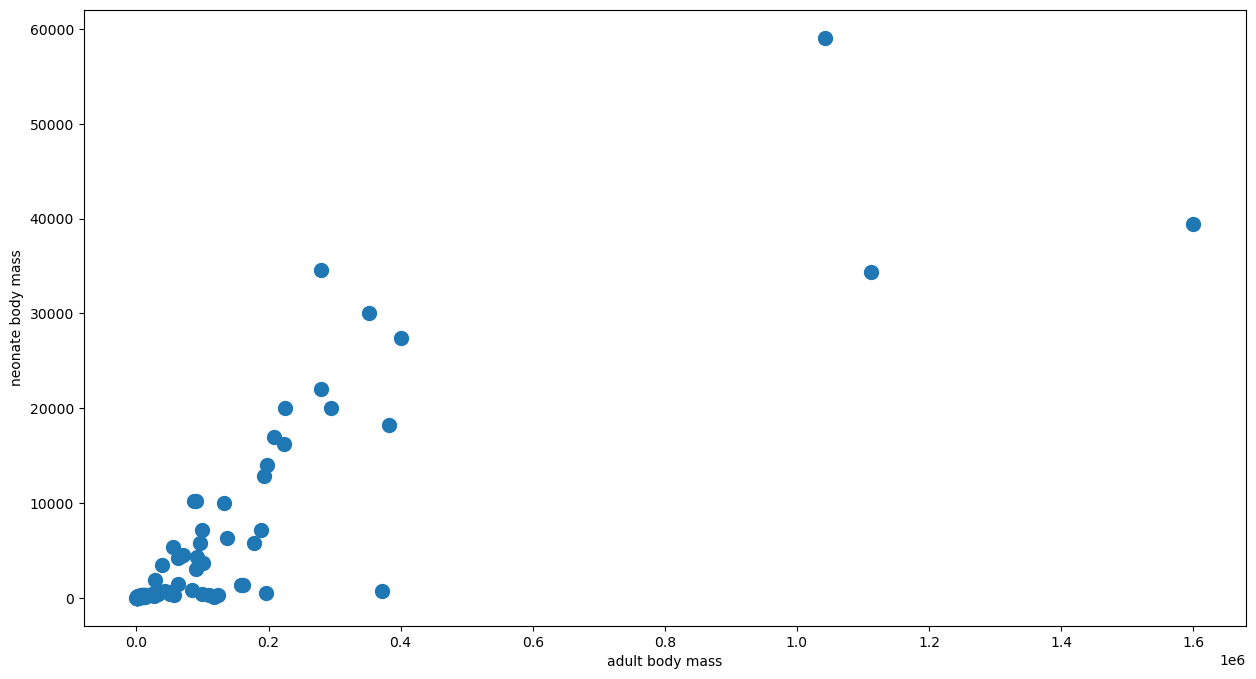

In [3]:
plt.scatter(carnivores.AdultBodyMass_g, carnivores.NeonateBodyMass_g, s=100);
plt.xlabel("adult body mass"); plt.ylabel("neonate body mass");

But - there's some "substructure"!

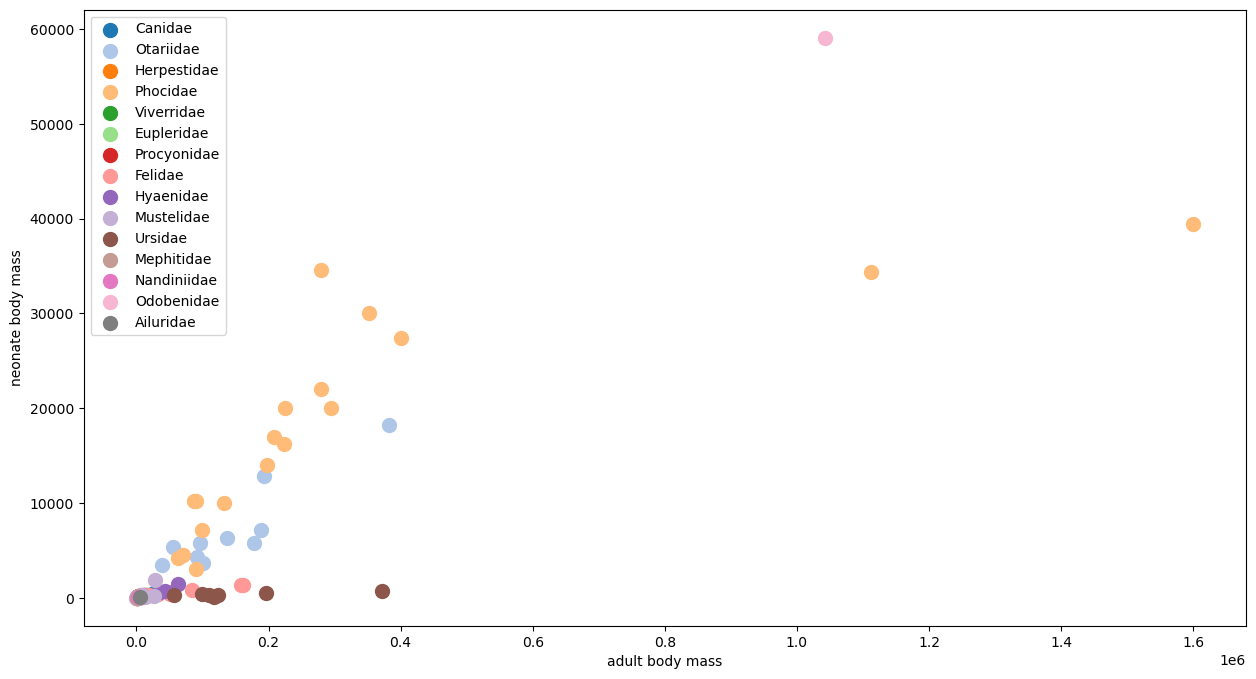

In [4]:
colors = {f: c for f, c in zip(carnivores.Family.unique(), plt.cm.tab20.colors)}
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.AdultBodyMass_g, sub.NeonateBodyMass_g, color=colors[f], s=100, label=f)
plt.xlabel("adult body mass"); plt.ylabel("neonate body mass");
plt.legend();

# First pass: a normal linear model

Let's fit a linear model and see what it's predictions are like:

In [5]:
from sklearn.linear_model import LinearRegression as lm
fit1 = lm().fit(carnivores[['AdultBodyMass_g']], carnivores.NeonateBodyMass_g)

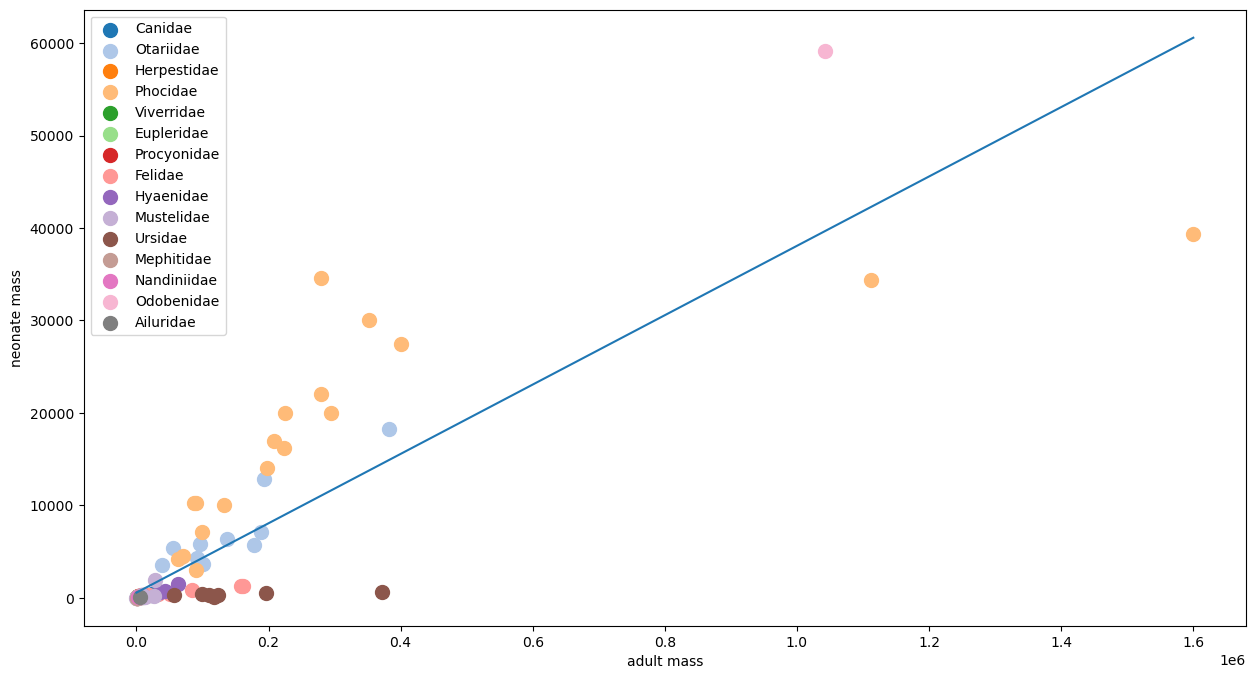

In [6]:
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.AdultBodyMass_g, sub.NeonateBodyMass_g, color=colors[f], s=100, label=f)
pred = pd.DataFrame({ "AdultBodyMass_g": np.linspace(np.min(carnivores.AdultBodyMass_g), 1.6e6, 201) })
pred['NeonateBodyMass_g'] = fit1.predict(pred)
plt.plot(pred.AdultBodyMass_g, pred.NeonateBodyMass_g)
plt.xlabel("adult mass"); plt.ylabel("neonate mass"); plt.legend();

# Heteroskedasticity?

# Diagnostics

Two good generic diagnostic plots are:

1. residuals versus fitted
2. distribution of residuals (histogram or QQ plot)

*What's the idea?*

1. If the residuals show predictable patterns, we could improve our model,
2. and if the residual SD differs systematically,
    we have *heteroskedasticity*
    (and so our model isn't using all the data very well).

## Patterns in the residuals

Here's data that are nonlinear but we don't know it:

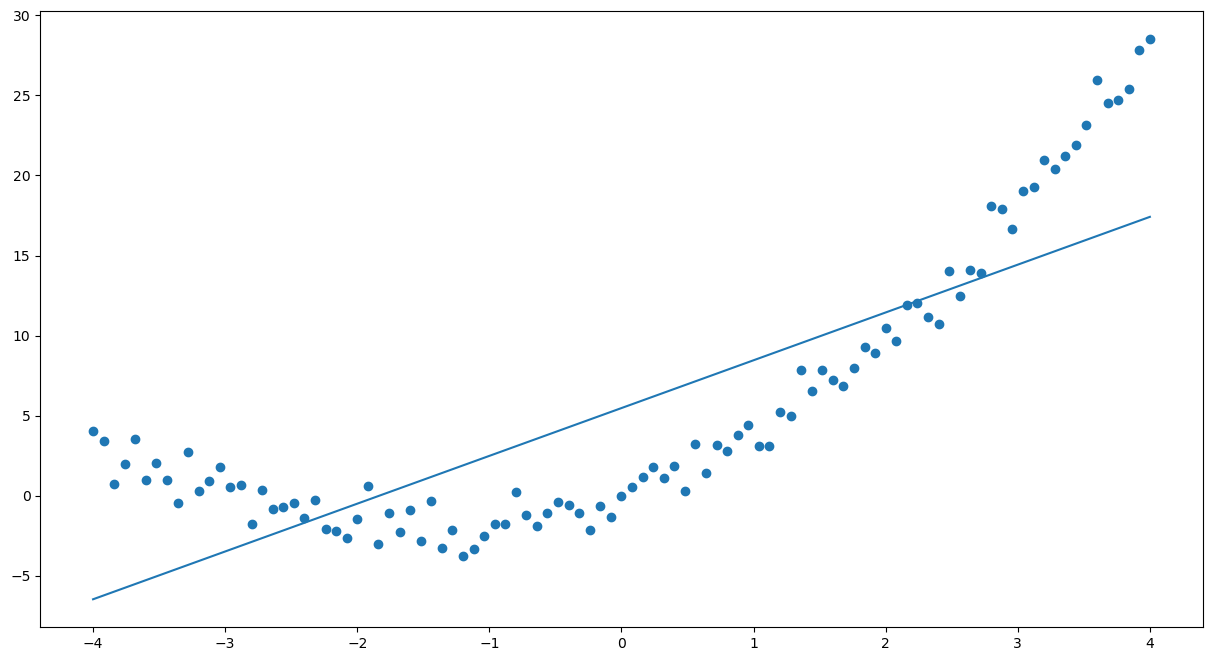

In [7]:
X = np.array([np.linspace(-4, 4, 101)]).T
y = rng.normal(loc=3*X+X**2, scale=1)
xy_lm = lm().fit(X, y)
yhat = xy_lm.predict(X)
plt.scatter(X[:,0], y)
plt.plot(X[:,0], yhat);

And, this shows up in the fit-versus-residuals plot:

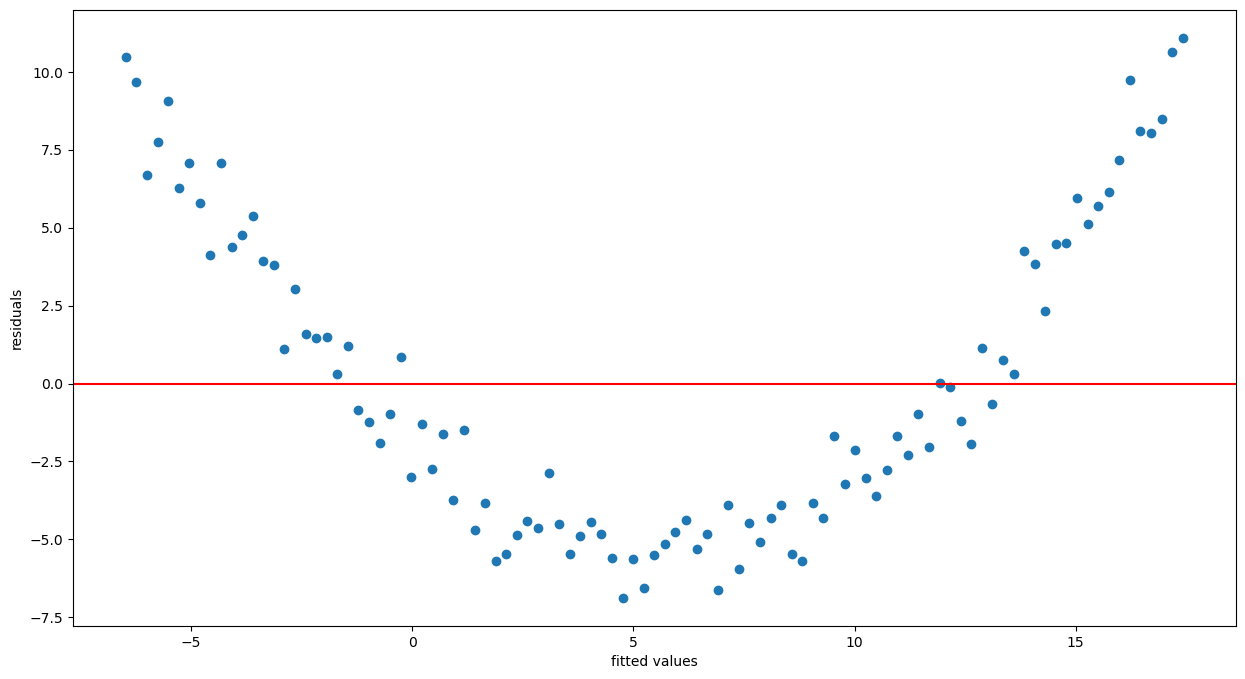

In [8]:
resids = y - yhat
plt.scatter(yhat, resids);
plt.axhline(0, color='red')
plt.xlabel("fitted values"); plt.ylabel("residuals");

Solution: add a quadratic term!

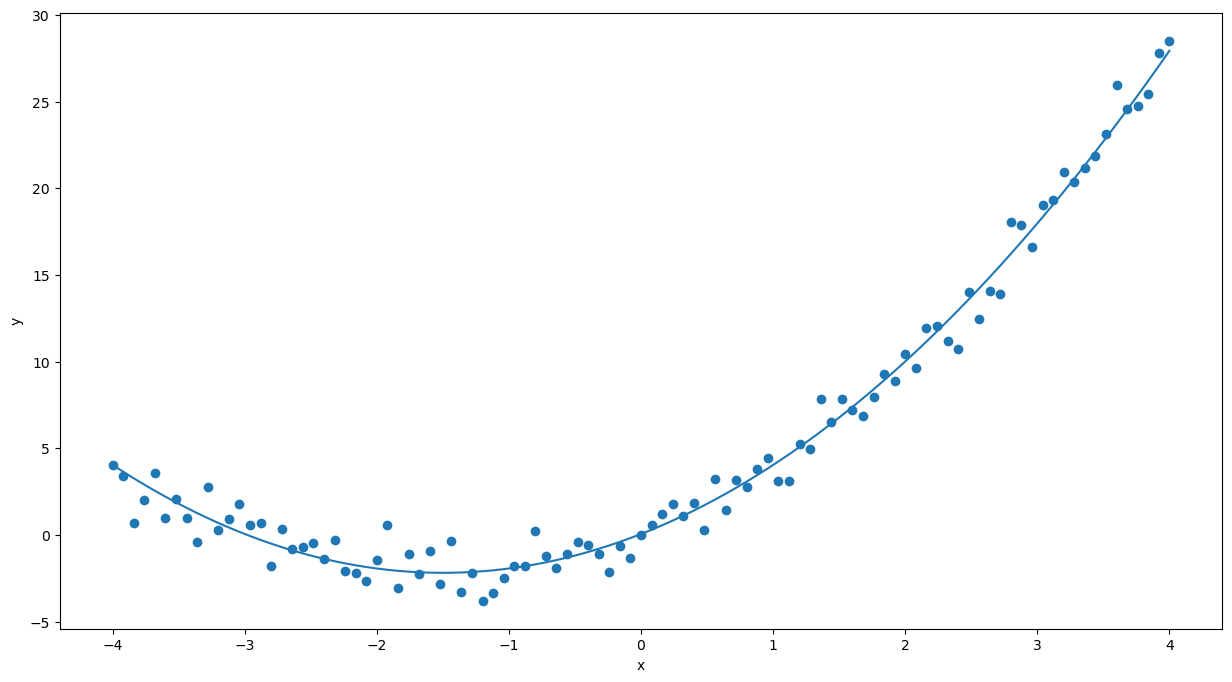

In [9]:
XX2 = np.hstack([X, X**2])
xy_lm = lm().fit(XX2, y)
yhat = xy_lm.predict(XX2)
plt.scatter(X[:,0], y); plt.plot(X[:,0], yhat); plt.xlabel("x"); plt.ylabel('y');

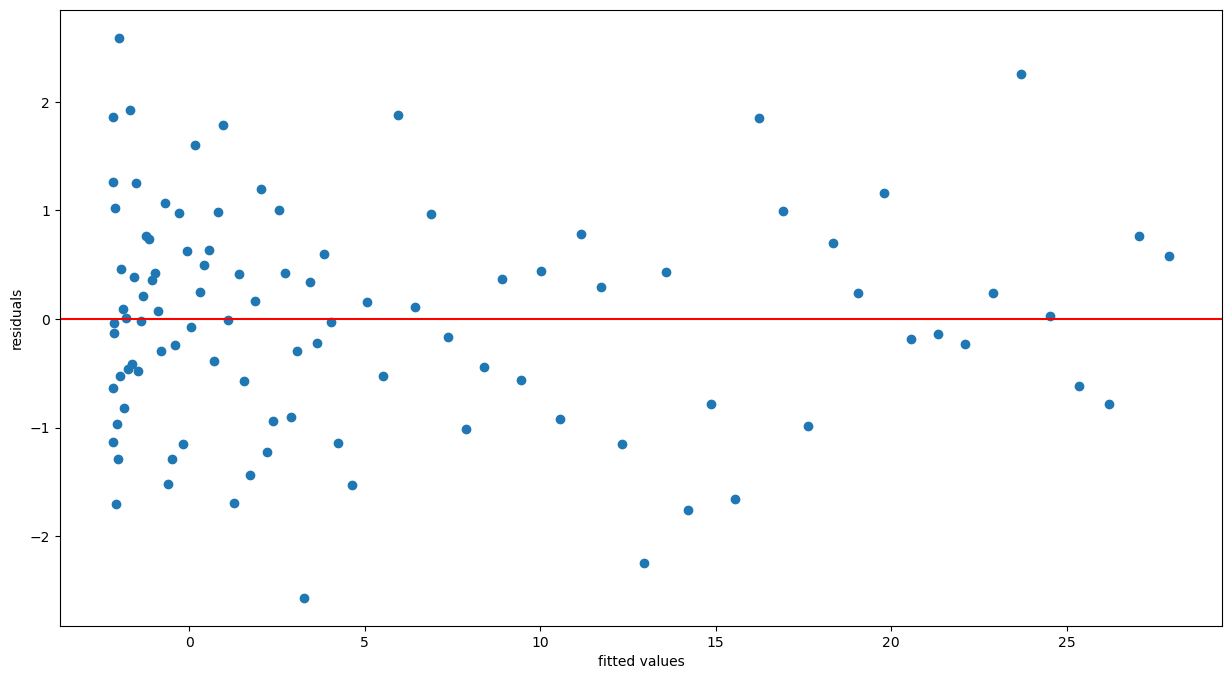

In [10]:
resids = y - yhat
plt.scatter(yhat, resids);
plt.axhline(0, color='red')
plt.xlabel("fitted values"); plt.ylabel("residuals");

# Back to our data

Let's look at this in our data:

In [11]:
carnivores['PredictedNeonateMass'] = fit1.predict(
    carnivores[['AdultBodyMass_g']]
)
carnivores['residual'] = carnivores['NeonateBodyMass_g'] - carnivores['PredictedNeonateMass']

In [12]:
carnivores

,Family,NeonateBodyMass_g,AdultBodyMass_g,AgeatEyeOpening_d,WeaningAge_d,PredictedNeonateMass,residual
Binomial,,,,,,,
Canis aureus,Canidae,211.82,9658.70,7.50,61.30,916.205446,-704.385446
Canis latrans,Canidae,200.01,11989.10,11.94,43.71,1003.630922,-803.620922
Canis lupus,Canidae,412.31,31756.51,14.01,44.82,1745.209715,-1332.899715
Canis mesomelas,Canidae,177.20,8247.30,NaN,34.10,863.256460,-686.056460
Callorhinus ursinus,Otariidae,5354.80,55464.82,0.00,108.69,2634.632251,2720.167749
...,...,...,...,...,...,...,...
Vulpes lagopus,Canidae,69.17,3584.37,15.03,49.50,688.325602,-619.155602
Vulpes velox,Canidae,39.94,2088.00,12.50,47.08,632.188948,-592.248948
Vulpes vulpes,Canidae,100.49,4820.36,14.01,50.71,734.694042,-634.204042


No particular pattern (?), but certainly: heteroskedasticity!

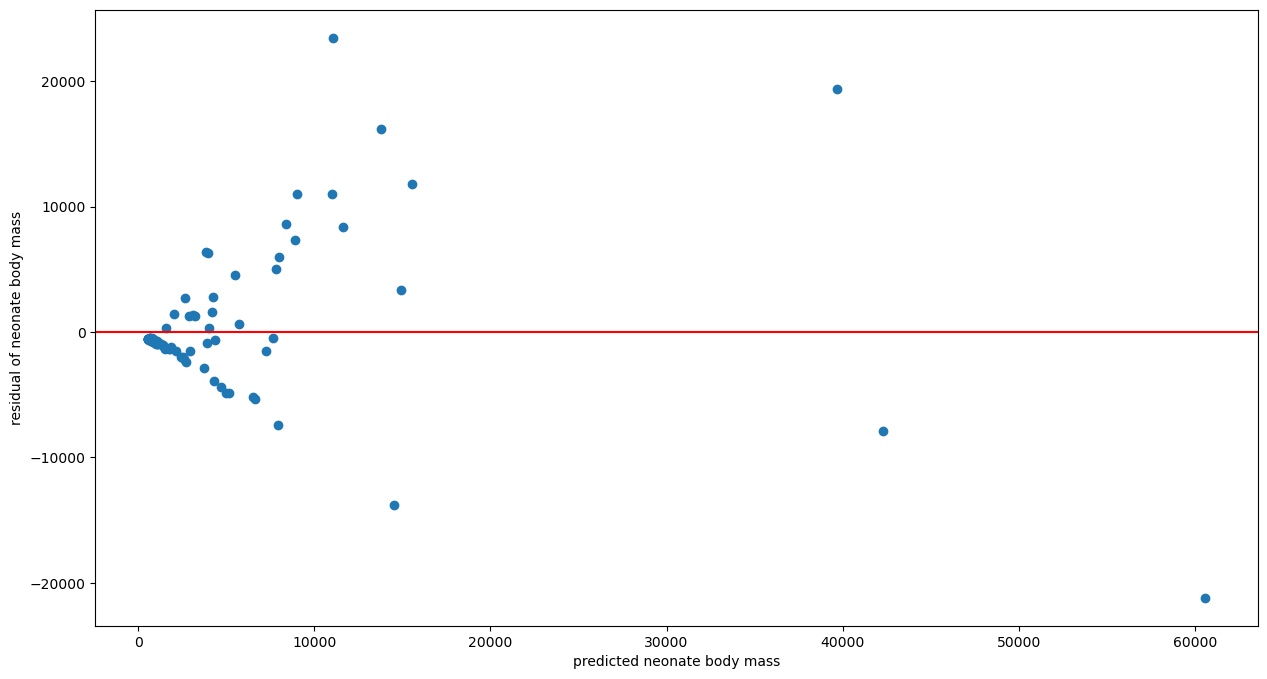

In [13]:
plt.scatter(carnivores.PredictedNeonateMass, carnivores.residual)
plt.axhline(0, color='red');
plt.xlabel("predicted neonate body mass"); plt.ylabel("residual of neonate body mass");

Why is heteroskedasticity a problem?
Above, we see that small body masses are all very close to the predicted line.
Indeed they have to be! A 5g weasel can't have a 100kg baby.
So: these small animals are not affecting the fit of that line very much at all.
Maybe that's okay - if we're interested in a relationship that holds
only for big animals, for instance -
but we should dig more.

# A transformation

One reason for having bad model fit
is that you aren't looking at the data through the right lens.

Most commonly:
if the data vary by *percent changes*,
then using standard methods (that assume *additive changes*)
won't do so great.
But, the **logarithm** turns percent changes
into additive changes!

Let's try it out.

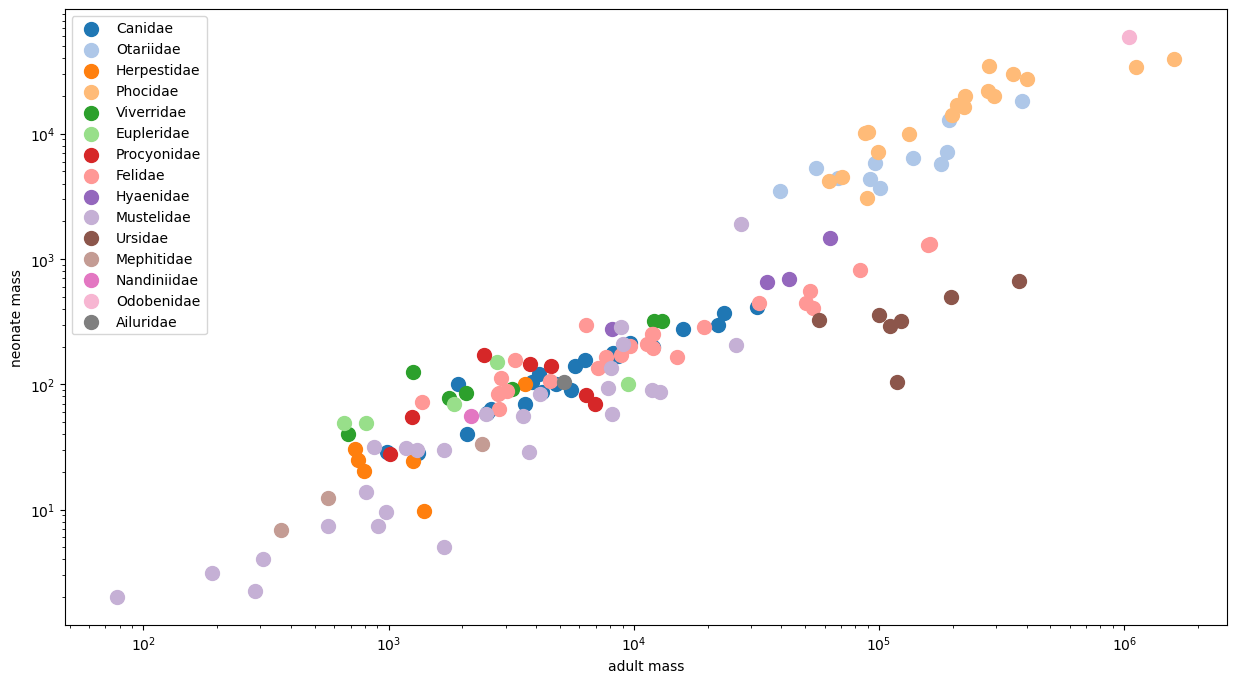

In [14]:
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.AdultBodyMass_g, sub.NeonateBodyMass_g, color=colors[f], s=100, label=f)
plt.xscale("log"); plt.yscale("log")  # log-log axes
plt.xlabel("adult mass"); plt.ylabel("neonate mass"); plt.legend();

Okay, let's now fit a model
to log(adult) and log(neonate) mass:

In [15]:
carnivores['logAdultBodyMass_g'] = np.log(carnivores['AdultBodyMass_g'])
carnivores['logNeonateBodyMass_g'] = np.log(carnivores['NeonateBodyMass_g'])
fit2 = lm().fit(carnivores[['logAdultBodyMass_g']], carnivores.logNeonateBodyMass_g)
carnivores

,Family,NeonateBodyMass_g,AdultBodyMass_g,AgeatEyeOpening_d,WeaningAge_d,PredictedNeonateMass,residual,logAdultBodyMass_g,logNeonateBodyMass_g
Binomial,,,,,,,,,
Canis aureus,Canidae,211.82,9658.70,7.50,61.30,916.205446,-704.385446,9.175614,5.355737
Canis latrans,Canidae,200.01,11989.10,11.94,43.71,1003.630922,-803.620922,9.391753,5.298367
Canis lupus,Canidae,412.31,31756.51,14.01,44.82,1745.209715,-1332.899715,10.365853,6.021775
Canis mesomelas,Canidae,177.20,8247.30,NaN,34.10,863.256460,-686.056460,9.017641,5.177279
Callorhinus ursinus,Otariidae,5354.80,55464.82,0.00,108.69,2634.632251,2720.167749,10.923504,8.585749
...,...,...,...,...,...,...,...,...,...
Vulpes lagopus,Canidae,69.17,3584.37,15.03,49.50,688.325602,-619.155602,8.184338,4.236567
Vulpes velox,Canidae,39.94,2088.00,12.50,47.08,632.188948,-592.248948,7.643962,3.687378
Vulpes vulpes,Canidae,100.49,4820.36,14.01,50.71,734.694042,-634.204042,8.480604,4.610058


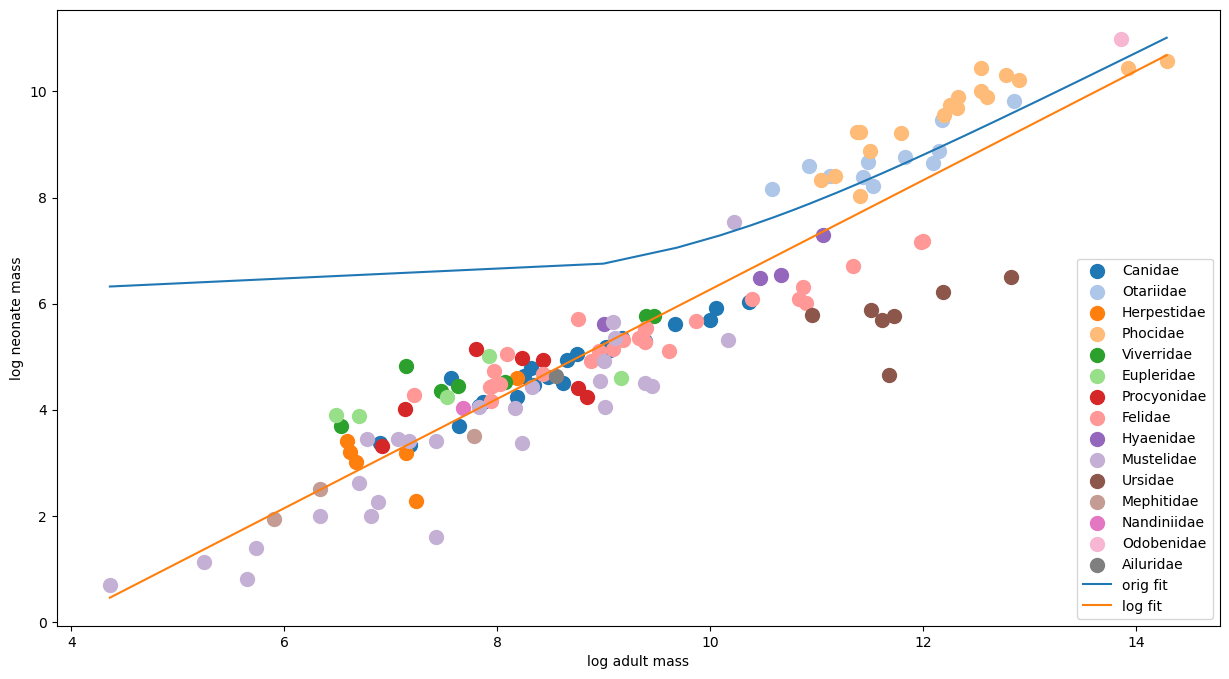

In [16]:
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.logAdultBodyMass_g, sub.logNeonateBodyMass_g, color=colors[f], s=100, label=f)
pred2 = pd.DataFrame({
    "logAdultBodyMass_g": np.linspace(np.min(carnivores.logAdultBodyMass_g),
                                      np.max(carnivores.logAdultBodyMass_g), 201)
})
pred2['logNeonateBodyMass_g'] = fit2.predict(pred2)
plt.plot(np.log(pred.AdultBodyMass_g), np.log(pred.NeonateBodyMass_g), label='orig fit')
plt.plot(pred2.logAdultBodyMass_g, pred2.logNeonateBodyMass_g, label='log fit')
plt.xlabel("log adult mass"); plt.ylabel("log neonate mass"); plt.legend();

In [17]:
fit2.coef_, fit2.intercept_, np.exp(fit2.intercept_), np.exp(np.std(np.log(pred.AdultBodyMass_g) - np.log(pred.NeonateBodyMass_g)))

(array([1.03054634]),
 -4.039480935997145,
 0.017606609001126764,
 1.4614248379177655)

Across carnivores, babies are about 1.8% the mass of adults, at birth,
mostly to within about 50% of that.

## Conclusions?

1. taking logs is definitely the way to fit these data
2. each family looks to have a different relationship
3. so a better model would allow different lines for each family

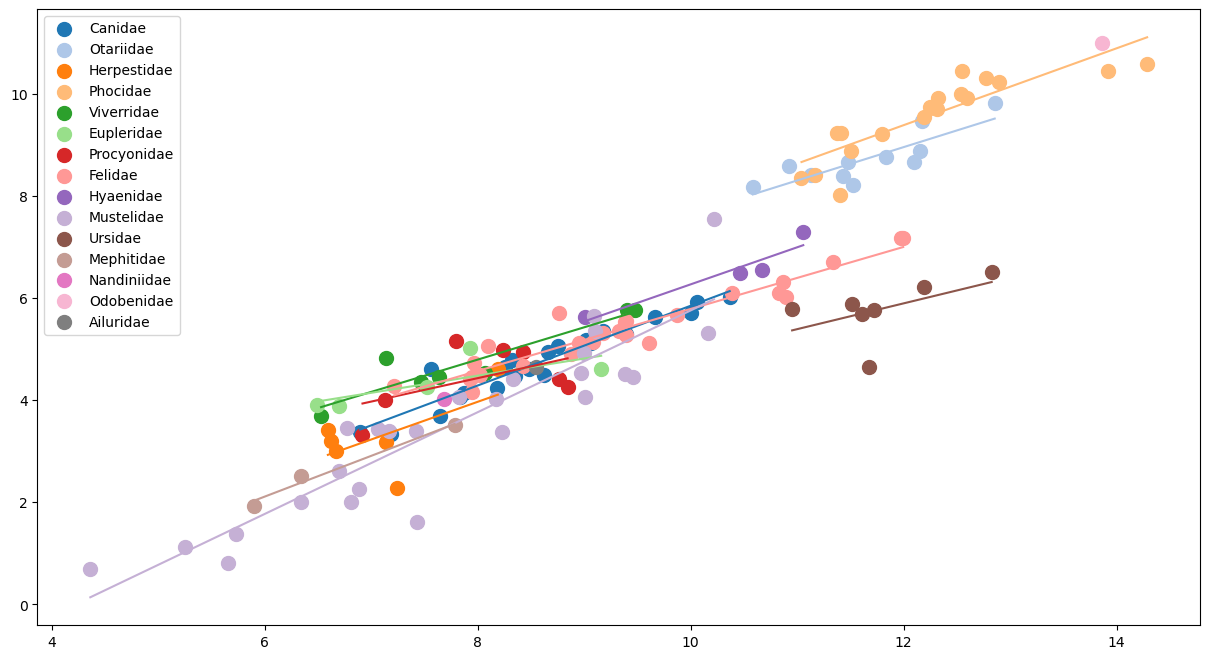

In [18]:
slopes = {}
for f in colors:
    sub = carnivores[carnivores.Family == f]
    fit_sub = lm().fit(sub[['logAdultBodyMass_g']], sub.logNeonateBodyMass_g)
    slopes[f] = fit_sub.coef_
    plt.scatter(sub.logAdultBodyMass_g, sub.logNeonateBodyMass_g, color=colors[f], s=100, label=f)
    pred_sub = pd.DataFrame({
        "logAdultBodyMass_g": np.linspace(np.min(sub.logAdultBodyMass_g),
                                          np.max(sub.logAdultBodyMass_g), 201)
    })
    pred_sub['logNeonateBodyMass_g'] = fit_sub.predict(pred_sub)
    plt.plot(pred_sub.logAdultBodyMass_g, pred_sub.logNeonateBodyMass_g, color=colors[f])
plt.legend();

Next steps: Fit the model with the additional variables
to see if maybe we don't need separate models by family any more?
Perhaps `AgeatEyeOpening_d` and `WeaningAge_d`?

In [19]:
is_nan = np.logical_or(np.isnan(carnivores.loc[:,"AgeatEyeOpening_d"]),
                       np.isnan(carnivores.loc[:,"WeaningAge_d"]))
next_data = carnivores.loc[~is_nan,:].copy()
pred_vars = ["logAdultBodyMass_g", "AgeatEyeOpening_d", "WeaningAge_d"]
next_X = next_data.loc[:,pred_vars]
next_fit = lm().fit(next_X, next_data[['logNeonateBodyMass_g']], )
next_data["predicted"] = next_fit.predict(next_data[pred_vars])

In [20]:
next_fit.coef_, fit2.coef_

(array([[ 8.93884874e-01, -4.98590099e-02, -3.01133804e-05]]),
 array([1.03054634]))

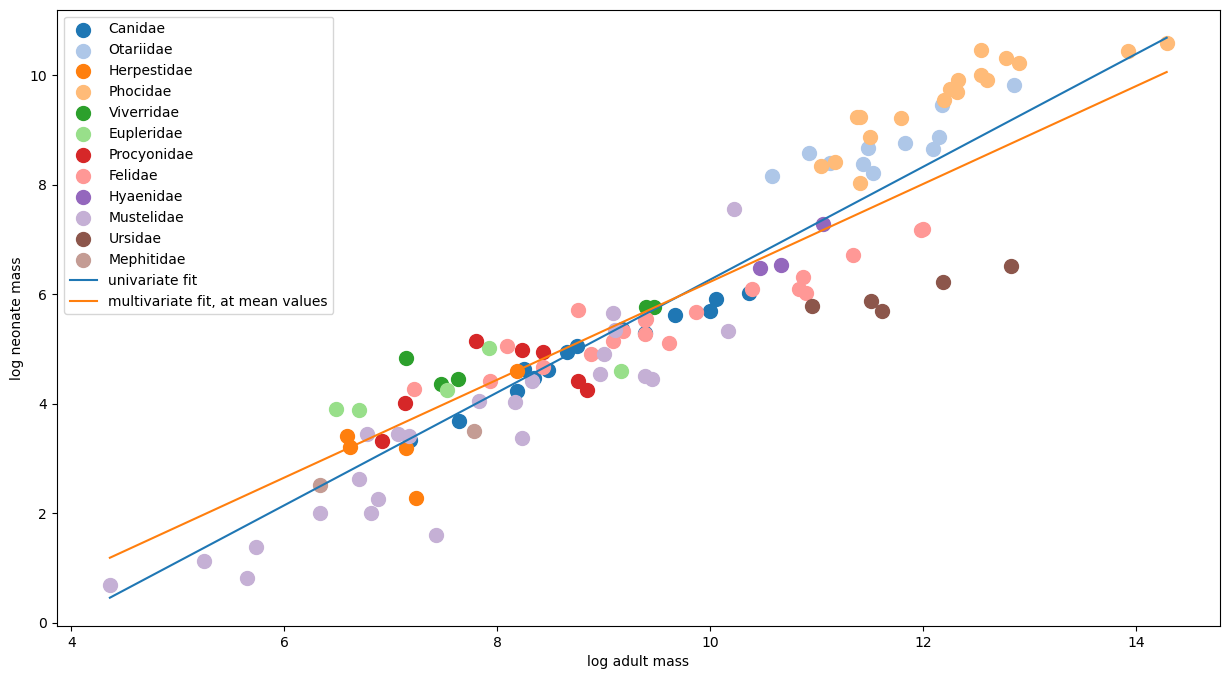

In [21]:
for f in colors:
    sub = next_data.loc[carnivores.Family == f,:]
    if sub.shape[0] > 1:
        plt.scatter(
            sub[['logAdultBodyMass_g']],
            sub[['logNeonateBodyMass_g']],
            color=colors[f], s=100, label=f
        )
pred2['AgeatEyeOpening_d'] = np.mean(next_data['AgeatEyeOpening_d'])
pred2['WeaningAge_d'] = np.mean(next_data['WeaningAge_d'])
pred2['next_pred'] = next_fit.predict(pred2[pred_vars])
plt.plot(pred2.logAdultBodyMass_g, pred2.logNeonateBodyMass_g, label='univariate fit')
plt.plot(pred2.logAdultBodyMass_g, pred2.next_pred, label='multivariate fit, at mean values')
plt.xlabel("log adult mass"); plt.ylabel("log neonate mass"); plt.legend();

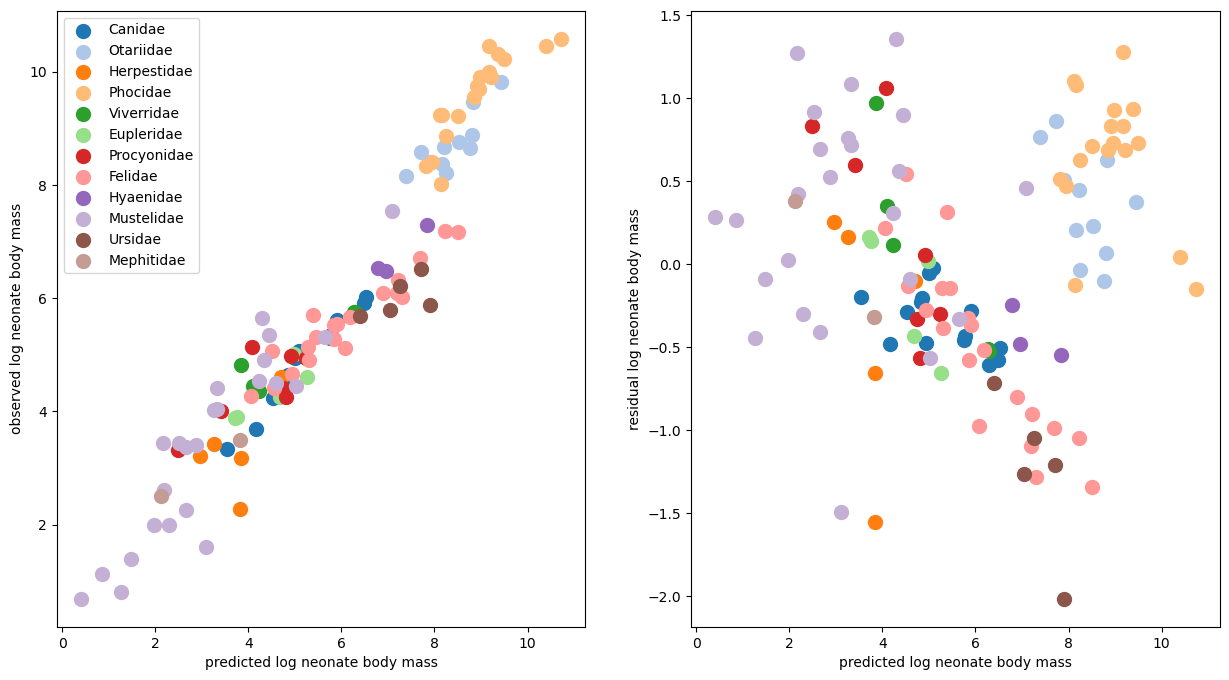

In [22]:
fig, (ax0, ax1) = plt.subplots(1, 2)

# observed versus predicted
for f in colors:
    sub = next_data.loc[carnivores.Family == f,:]
    if sub.shape[0] > 1:
        ax0.scatter(
            sub[['predicted']],
            sub[['logNeonateBodyMass_g']],
            color=colors[f], s=100, label=f
        )
ax0.set_xlabel("predicted log neonate body mass")
ax0.set_ylabel("observed log neonate body mass")

# residual versus predicted

for f in colors:
    sub = next_data.loc[carnivores.Family == f,:]
    if sub.shape[0] > 1:
        ax1.scatter(
            sub[['predicted']],
            sub.loc[:,'logNeonateBodyMass_g'] - sub.loc[:,'predicted'],
            color=colors[f], s=100, label=f
        )
ax1.set_xlabel("predicted log neonate body mass")
ax1.set_ylabel("residual log neonate body mass")
ax0.legend();

In [23]:
orig_resids = next_data.loc[:,'logNeonateBodyMass_g'] - fit2.predict(next_data[["logAdultBodyMass_g"]])
new_resids = next_data.loc[:,'logNeonateBodyMass_g'] - next_data.loc[:,'predicted']

print(f"The standard deviation of the residuals for the original, univariate model was "
      f"{np.std(orig_resids):.2f}, and the for the multivariate model with eye opening and weaning times, "
      f"it is {np.std(new_resids):.2f}."
)

The standard deviation of the residuals for the original, univariate model was 0.87, and the for the multivariate model with eye opening and weaning times, it is 0.68.
